In [48]:
from bs4 import BeautifulSoup
import requests
import geopandas
import pandas as pd
import geoplot
import requests
import matplotlib.pyplot as plt

In [2]:
url = "https://cfpub.epa.gov/enforcement/cases/"
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')
intro_table, table = soup.find_all('table')
[table_body] = table.find_all("tbody")
table_rows = table_body.find_all("tr")

In [3]:
def process_row(r):
    try:
        columns = r.find_all("td")
        res = dict(
            link = columns[0].a["href"],
            respondent = columns[0].text.strip(),
            description = columns[1].text.strip(),
            order_type = columns[2].text.strip(),
            date = columns[3].text.strip()
        )
        return res
    except:
        return None
    
df = pd.DataFrame(list(filter(None, [process_row(r) for r in table_rows])))

In [14]:
df.to_csv("legal.csv", index=False)

In [23]:
water_payload = {
    "start": "2021-03-01",
    "end": "2021-04-30",
    "filterby": "scrape_date",
    "themes": "water",
    "states": "all"
}

fire_payload = {
    "start": "2021-03-01",
    "end": "2021-04-30",
    "filterby": "scrape_date",
    "themes": "fire",
    "states": "all"
}

base_url = "http://wtl.earthrise.media/retrieve"

water = requests.get(base_url, params=water_payload)
fire = requests.get(base_url, params=fire_payload)

<Response [200]>

In [24]:
def _process_record(r):
    lat, lon = r["Latlon"]
    
    return dict(
        title = r["Title"],
        lat = lat,
        lon = lon,
        location = r["Location"]
    )
    

water_df = pd.DataFrame([_process_record(r) for r in water.json()])
fire_df = pd.DataFrame([_process_record(r) for r in fire.json()])

In [31]:
fire_df["event"] = "fire"
water_df["event"] = "water"
df = pd.concat([water_df, fire_df], ignore_index=True)

In [109]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat)).set_crs('EPSG:4326')

contiguous_usa = geopandas.read_file(geoplot.datasets.get_path('contiguous_usa'))

(-14201398.969298434,
 -7133189.608680231,
 2695394.5884269234,
 6480782.290752688)

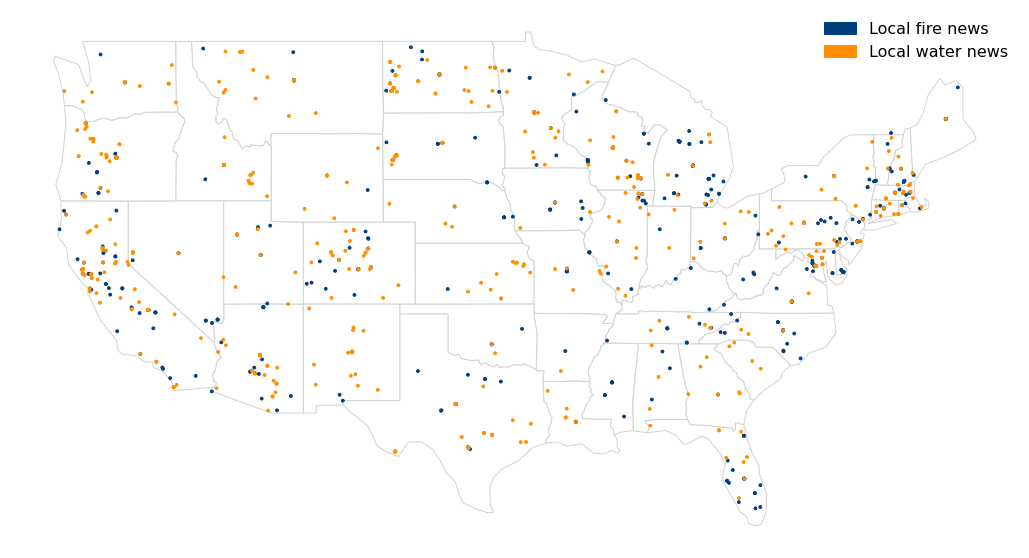

In [131]:
import matplotlib.patches as mpatches

event_color_dict = {"water": '#003F7D', "fire": '#FF8E00'}
gdf["event_color"] = [event_color_dict[x] for x in gdf["event"]]



ax = contiguous_usa.to_crs('EPSG:3395').plot(
    edgecolor='lightgrey', 
    color='white', 
    figsize=(20,10)
)

gdf.to_crs('EPSG:3395').plot(
    ax=ax,
    marker='o', 
    markersize=8,
    color=gdf["event_color"]
)

fire_patch = mpatches.Patch(color='#FF8E00', label='Local water news')
water_patch = mpatches.Patch(color='#003F7D', label='Local fire news')
ax.legend(
    handles=[water_patch, fire_patch],
    frameon=False,
    fontsize=16
)

ax.set_xlim([-14201398.969298434, -7133189.608680231])
ax.set_ylim([2695394.5884269234, 6480782.290752688])
ax.set_aspect('equal')
ax.axis('off')
plt.savefig('zoom.png', dpi=300)